# Table of Contents
- [Imports](#imp)
- [cleaning](#clean)
- [visualization](#vis)
    - [mapping](#map)
        - [animation](#anim)
    - [time series](#time)
        - [time series](#1)
        - [winter t-max change](#2)
        - [winter t-min change](#3)
- [conclusion](#conc)

<a id='imp'></a>
## Imports

In [152]:
import warnings
from typing import Optional
import time
import datetime
import  netCDF4 as nc
from netCDF4 import Dataset as NetCDFFile, date2index, num2date
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import numpy  as np
import pandas as pd
from scipy import stats

In [164]:
try:
    path =r'C:\\Users\\oeb\\AppData\\Local\\Programs\\FFmpeg\\bin\\ffmpeg.exe'
    matplotlib.rcParams['animation.ffmpeg_path'] = path
except:
    pass

In [2]:
path_tmax= "Central_North_Egypt_(CNE_V1.0)_Tmax_1981-2017.nc"
path_tmin= "Central_North_Egypt_(CNE_V1.0)_Tmin_1981-2017.nc"
data = nc.Dataset(path_tmax);   data_tmin = nc.Dataset(path_tmin); 

In [3]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Central North Region of Egypt Maximum Temperature Dataset
    short title: CNE Tmax
    Version: CNE_01
    Time Span: 1/1/1981 - 31/12/2017
    DOI: 10.6084/m9.figshare.7504232
    references: NA
    history: M.S. Nashwan On Sun Dec 23 17:18:07 2018
    institution: Construction and Building Engineering, College of Engineering and Technology, Arab Academy for Science, Technology and Maritime Transport (AASTMT), Cairo, 2033 - Elhorria, Egypt
    Title: Central North Region of Egypt Maximum Temperature Dataset
    Short title: CNE Tmax
    References: Nashwan, M. S., Shahid, S., & Chung, E.-S. (2019). Development of high-resolution daily gridded temperature datasets for the central north region of Egypt. Scientific Data, 6(1), 138. doi:10.1038/s41597-019-0144-0
    History: M.S. Nashwan On Wed Aug 07 21:51:01 2019
    Institute: Construction and Building Engineering, College of En

In [4]:
data['temperature']

<class 'netCDF4._netCDF4.Variable'>
float32 temperature(Day, lat, lon)
    units: celsius
unlimited dimensions: 
current shape = (13514, 42, 71)
filling on, default _FillValue of 9.969209968386869e+36 used

In [5]:
data['temperature'][:][9000:9002,0,0]

masked_array(data=[35.86, 36.6 ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [6]:
data.variables['lon'][0:10]

masked_array(data=[29.5 , 29.55, 29.6 , 29.65, 29.7 , 29.75, 29.8 , 29.85,
                   29.9 , 29.95],
             mask=False,
       fill_value=1e+20)

In [7]:
data['Day'].shape

(13514,)

In [3]:
lats = data['lat'][:]
lons = data['lon'][:]
times = data['Day'][:]
tempreture_data = data['temperature'][:][:,:,:]

In [4]:
lats_ = data_tmin['lat'][:]
lons_ = data_tmin['lon'][:]
times_ = data_tmin['Day'][:]
tempreture_data_ = data_tmin['temperature'][:][:,:,:]

<a id='clean'></a>
## ***cleaning***

In [10]:
tempreture_data[0,:,:].data

array([[18.31, 18.31, 18.21, ..., 18.07, 17.98, 17.38],
       [18.31, 18.32, 18.05, ..., 17.77, 17.57, 17.28],
       [18.23, 18.25, 18.06, ..., 17.97, 17.58, 17.08],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]], dtype=float32)

In [11]:
np.isnan(tempreture_data[-5,:,:]).sum()

394

In [12]:
tempreture_data[0,:,:][~np.isnan(tempreture_data[0,:,:])].mean()

18.38968

In [13]:
nulls = np.isnan(tempreture_data).sum() # 5 millions
print(nulls)

5324516


In [14]:
np.isnan(data_tmin.variables['temperature']).sum()

5324516

In [15]:
int(tempreture_data[:,:,:].flatten().shape - nulls) # 35 mil is not nul

34974232

In [16]:
# wrong it gets diffrent shape cannot reshape it to the original
cleaned_temp = tempreture_data.copy()
cl = cleaned_temp[:,:,:][~np.isnan(cleaned_temp[:,:,:])]
cl.shape

(34974232,)

In [48]:
cleaned_temp = tempreture_data.copy()
cleaned_temp_min = tempreture_data_.copy()

for i in range(len(times)):
    # the diffrence in shapes will generate error
    #cleaned_temp[i,:,:]= cleaned_temp[i,:,:][~np.isnan(cleaned_temp[i,:,:])]

    cleaned_temp[i,:,:][np.isnan(cleaned_temp[i,:,:])]= np.nanmean(cleaned_temp[i,:,:])
    cleaned_temp_min[i,:,:][np.isnan(cleaned_temp_min[i,:,:])]= np.nanmean(cleaned_temp_min[i,:,:])

In [18]:
tempreture_data[:,:,:].shape,type(tempreture_data),cleaned_temp[:,:,:].shape,type(cleaned_temp)

((13514, 42, 71),
 numpy.ma.core.MaskedArray,
 (13514, 42, 71),
 numpy.ma.core.MaskedArray)

**we filled the nans on every day data with mean temp on that day** 

<a id='vis'></a>
## ****Visualization****

In [ ]:
def int_datetime(tit:int)->str:
    
    tit = str(tit)
    day   = tit[6:-2]
    month = tit[4:-4]
    year  = tit[0:-6]
    date = year+'-'+month+'-'+day
    return date

def get_titles(lis:list([int]),
    )->list([datetime.datetime]):
    
    titles = map(lambda x:int_datetime(x) ,lis)
    titles = map(lambda x:datetime.datetime.strptime(x,"%Y-%m-%d") 
        ,titles)
    
    return list(titles)

def get_str_titles(lis:list([int]),
    label:str,
    )->list([str]):
    
    titles = map(lambda x: label +int_datetime(x) ,lis)
    
    return list(titles)

def adder(a:float,per:float)->float:
    return a + per

def reduce_list(lis:list,
    values: Optional[int]=3,
        )->list:
    lis = lis[~np.isnan(lis)]
    
    high = round(float(lis.max()),2)
    low  = round(float(lis.min()),2)
    mid  = round( (low+high)/2.0 ,2)
    
    per  = round(0.01*low,2)
    low  = round(adder(low, per),2)
    # negative
    high = round(adder(high,-1* per),2)
    reduced = [low, mid, high]
    return reduced

print(reduce_list(tempreture_data[900, :, :]))

[21.57, 27.18, 32.79]


In [ ]:
class Maps():

    def __init__(self,
            grad_va:int=400,
            grad_victor:int=70,
            #proj_res: Optional[str] = None,
            proj_res: str = 'h',
            ):
        self.grad_victor = grad_victor
        self.proj_res = proj_res
        self.grad_va = grad_va
        self.cmap = 'RdBu_r'
        self.cs_grad = None
        self.cbar = None
        self.map_ = None
        self.fig = None
        self.cs = None
        self.x = None
        self.y = None

    def _setup(self,
        fig_size:tuple((int,int)))->None:
        # set 
        fig = plt.figure(figsize=fig_size,
            facecolor=None,
            frameon=False,
            dpi = 1920 / max(fig_size) )

        ax = fig.add_subplot()
        ax.set_facecolor(color=None)
        fig.patch.set_alpha(0.0)
        self.fig = fig
        return fig

    def _map_init(self,
            records_values:list,
            longs_values:list,
            lats_values:list,
            lat_0:float = 30.8,
            width:float = 0.35E6,
            lon_0:float = 31.24,
            height:float= 0.299E6):

        self.map_ = Basemap(projection='lcc', resolution=self.proj_res,
            lat_0=lat_0, lon_0=lon_0,
            width=width, height=height);

        self.map_.shadedrelief();
        temp_cyclic, lons_cyclic = addcyclic(records_values, longs_values);
        # Create 2D lat/lon arrays for Basemap
        lon2d, lat2d = np.meshgrid(lons_cyclic, lats_values);
        # Transforms lat/lon into plotting coordinates for projection
        x, y = self.map_(lon2d, lat2d);
        self.x = x
        self.y = y
        return temp_cyclic

    def plot(self,
        records_values:list,
        longs_values:list,
        lats_values:list,
        plot_title:str,
        cbar_label:str,
        lat_0:float = 30.8,
        width:float = 0.35E6,
        lon_0:float = 31.24,
        height:float= 0.299E6,
        fig_size:tuple((int,int))= (10,10),
        cbar_title:str='temp in ⁰c',
        cmap:str = 'RdBu_r',
        animation_res: Optional [int] = 1920,
            )->None:

        self.fig = self._setup(fig_size)
        temp_cyclic = self._map_init(records_values=records_values,
            longs_values=longs_values,
            lats_values=lats_values,lat_0=lat_0,
            width=width,lon_0=lon_0,height=height
        )
        
        cmap = plt.cm.get_cmap(cmap)
        # drawing contours
        self.cs = self.map_.contourf(self.x, self.y, temp_cyclic, self.grad_va, cmap=cmap)
        self.cs_grad = self.map_.contour(self.x, self.y, temp_cyclic, self.grad_victor,
                linewidths=0.05, colors='k')
        self.cbar = plt.colorbar(self.cs, shrink=0.7)
        
        # cbar labels
        labels = reduce_list(records_values)
        self.cbar.set_ticks(ticks=labels,labels=labels)
        self.cbar.set_label(cbar_title,color='black',)
        # plot title
        plt.title(plot_title)
        return

    def cleaner(self)->None:
        def clean(lis):
            [i.remove() for i in lis]

        [clean(c.collections) for c in [self.cs_grad,self.cs]]
        self.cbar.remove()
    
    def animate(self,
        records_values:list([list([float])]),
        longs_values:list,
        lats_values:list,
        plot_titles:list([str]),
        cbar_label:str,
        lat_0:float = 30.8,
        width:float = 0.35E6,
        lon_0:float = 31.24,
        height:float= 0.299E6,
        fig_size:tuple((int,int))= (10,10),
        cbar_title:str='temp in ⁰c',
        cmap:str = 'RdBu_r',
        animation_res:int = 1920,
        interval:int=100,
        animation_vid_name:str='anim.mp4',
        )->animation:

        cmap = plt.cm.get_cmap(self.cmap)
        
        def update(frame,):
            # clean figure
            self.cleaner()
            
            # drawing contours
            temp_cyclic, lons_cyclic = addcyclic(records_values[frame], longs_values);

            self.cs = self.map_.contourf(self.x, self.y, temp_cyclic,self.grad_va, cmap=cmap);
            self.cs_grad = self.map_.contour(self.x ,self.y,temp_cyclic,self.grad_victor,
                    linewidths=0.05,colors='k');
            self.cbar = plt.colorbar(self.cs, shrink=0.7);

            # cbar labels
            labels = reduce_list(records_values[frame])
            self.cbar.set_ticks(ticks=labels,labels=labels) 
            self.cbar.set_label(cbar_title,color='black',);
            # plot title
            plt.title(plot_titles[frame])

            return
        # init
        self.plot(
            records_values=records_values[0],
            longs_values=longs_values,
            lats_values=lats_values,
            plot_title=plot_titles[0],
            cbar_label=cbar_label,
            lat_0=lat_0,width=width,
            lon_0=lon_0,height=height,
            fig_size=fig_size,
            cbar_title=cbar_title,
            cmap=cmap,
            animation_res=animation_res,
            )
        frms = len(records_values)
        anim = animation.FuncAnimation(self.fig, update,
                                    frames=frms,interval=interval, blit=False)
        writervideo = animation.FFMpegWriter()
        
        anim.save(animation_vid_name, writer=writervideo,
                savefig_kwargs={'transparent': True, 'facecolor': None})
        
        return anim

<a id='map'></a>
### ***map***

In [6]:
# to ignore annoying python warnings
warnings.filterwarnings('ignore')

In [20]:
lats.shape, lons.shape, tempreture_data.shape

((42,), (71,), (13514, 42, 71))

In [21]:
max(lats),min(lats)

(31.55, 29.5)

In [144]:
ma = Maps(proj_res='l')

In [ ]:
titles = get_str_titles(times,"Avg temp in ")
titles[0]

'Avg temp in 1981-01-01'

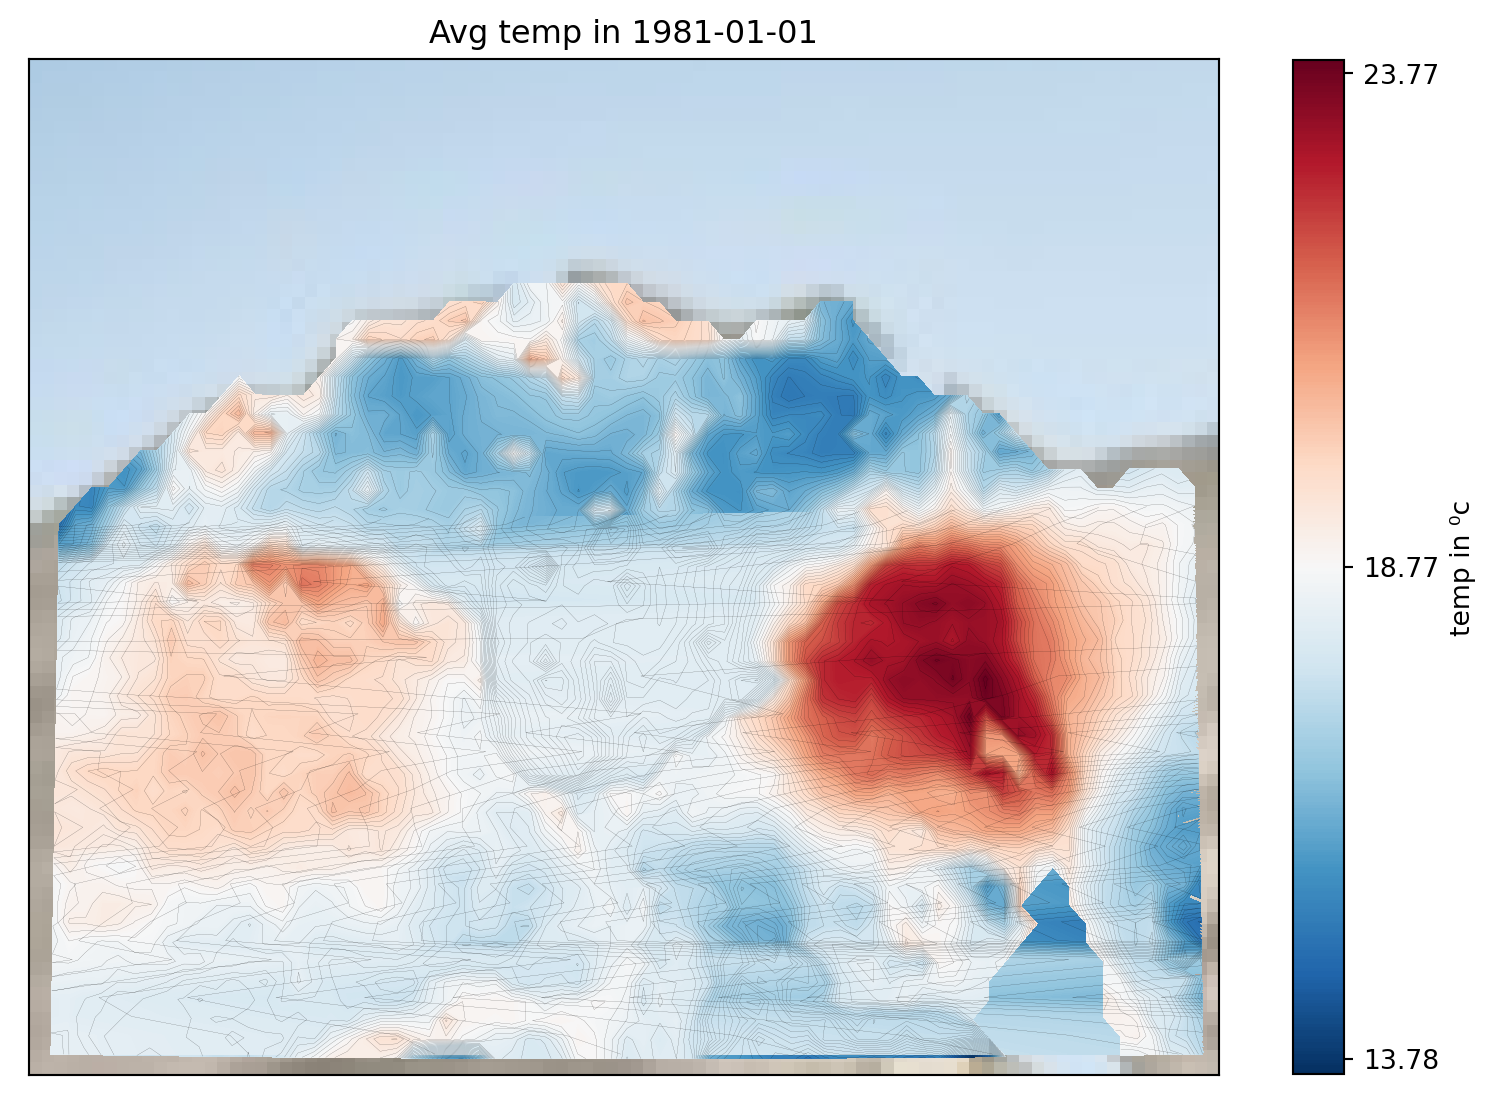

In [157]:
ma.plot(records_values=tempreture_data[0, :, :], longs_values=lons,
 lats_values=lats, plot_title=titles[0], cbar_label='temp [⁰c]',)

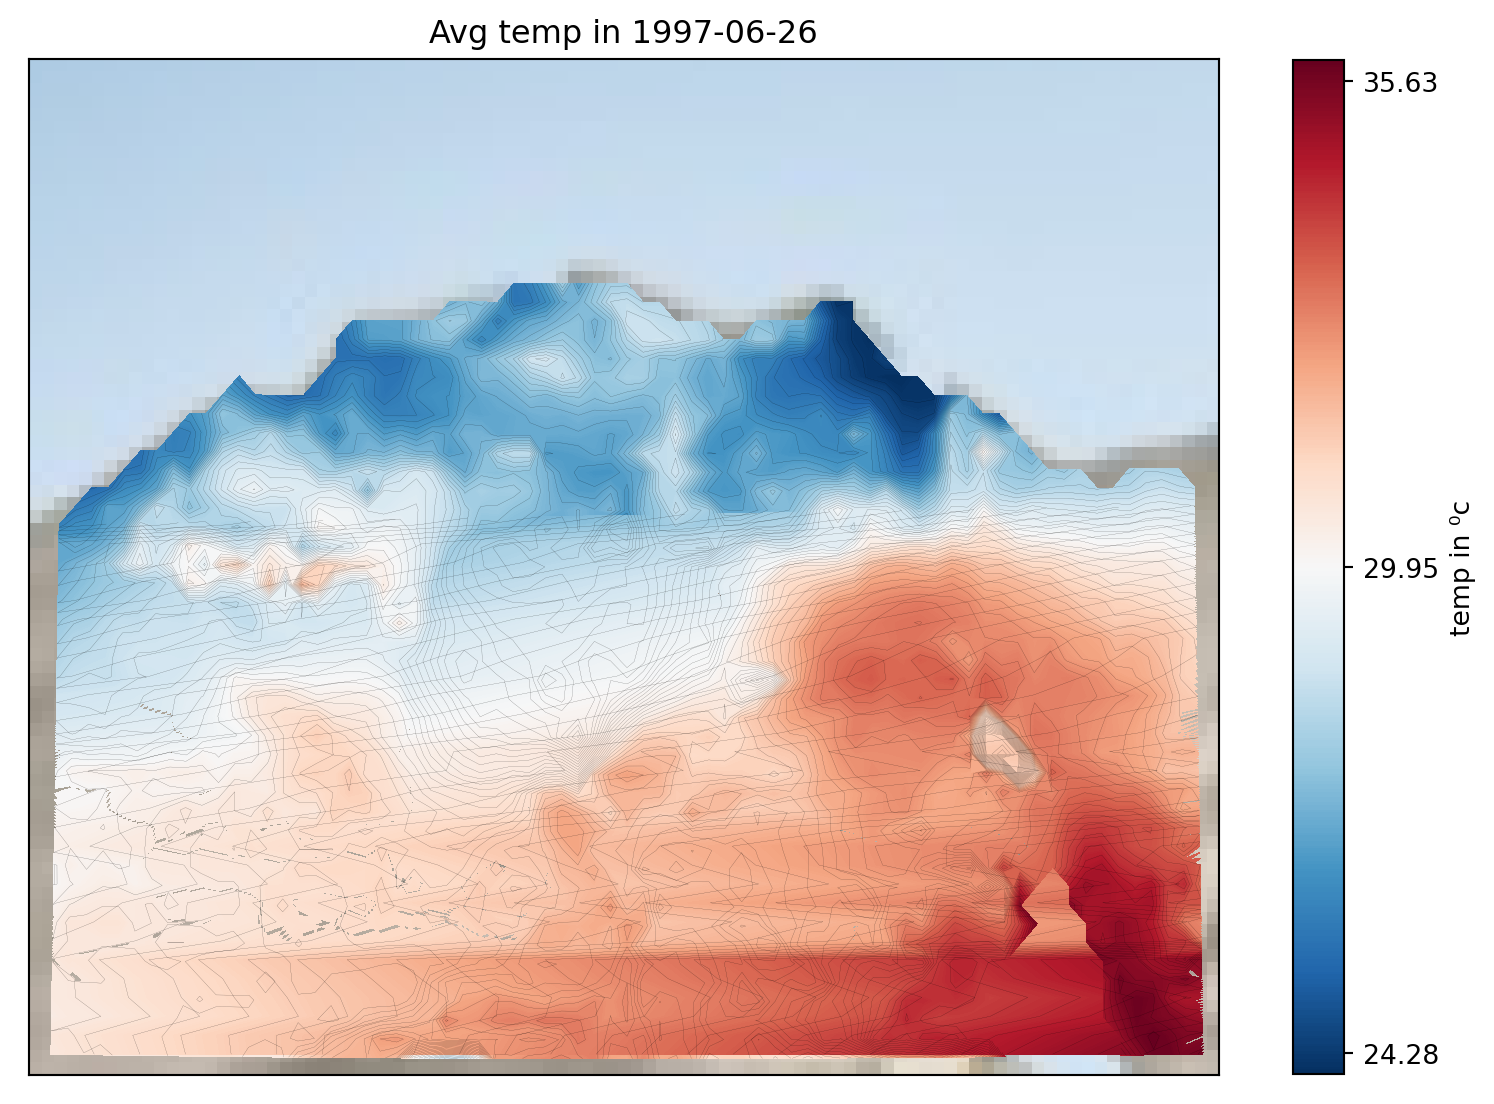

In [156]:
ma.plot(records_values=tempreture_data[6020, :, :], longs_values=lons,
 lats_values=lats, plot_title=titles[6020], cbar_label='temp [⁰c]',)

<a id='anim'></a>
#### **Animation**


In [146]:
# change in temp in jan and feb
indces= sorted([ j*365+ i   for i in range(60)   for j in range(2017-1981+1) ])
jan_feb_tempretures = tempreture_data[indces]
jan_feb_titles = [titles[i] for i in indces]

In [159]:
from IPython.display import Video

***this animation is huge please consider open it with a video player***

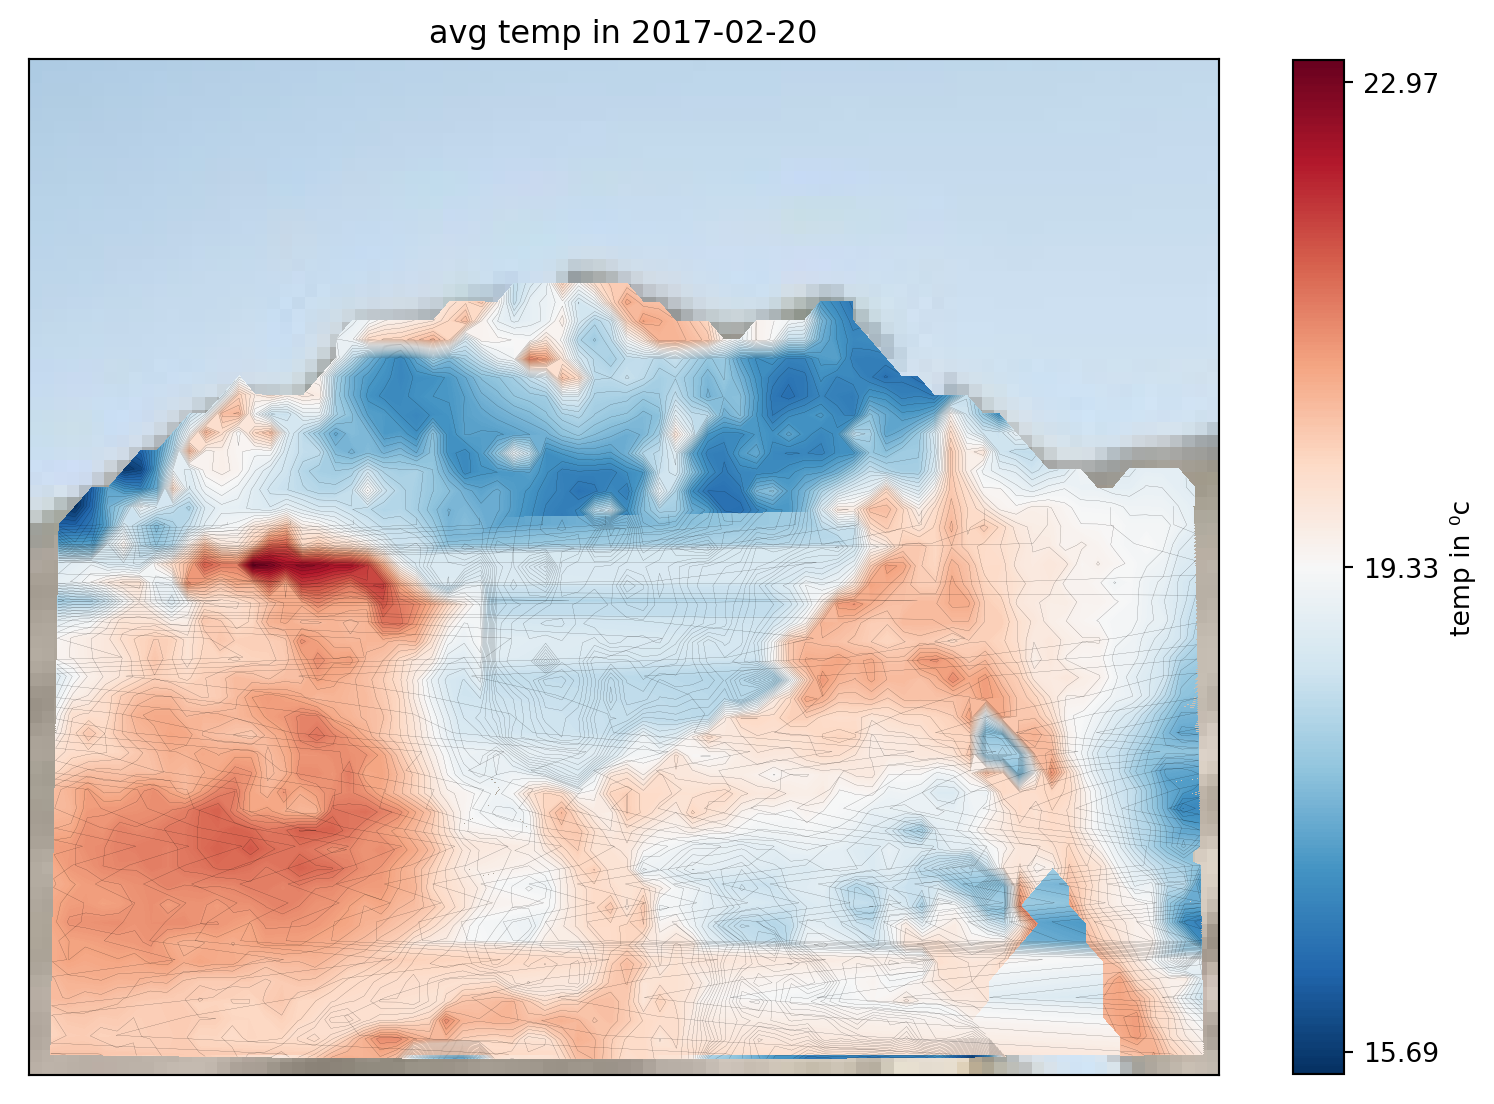

In [147]:
ma.animate(records_values = jan_feb_tempretures, longs_values=lons,
 lats_values=lats, plot_titles=jan_feb_titles, cbar_label='temp [⁰c]',
 animation_res=720,animation_vid_name="temperatue_animation.mp4")

In [160]:
Video("temperatue_animation.mp4")

In [163]:
ma.animate(records_values = tempreture_data[50:100, :, :], longs_values=lons,
 lats_values=lats, plot_titles=titles[50:100], cbar_label='temp [⁰c]',
 animation_res=720,animation_vid_name="temperatue_animation_50_days.mp4");
plt.close();

In [162]:
Video("temperatue_animation_50_days.mp4")

<a id='time'></a>
### ***time series***

<a id='1'></a>
#### **temp change daily over the years**

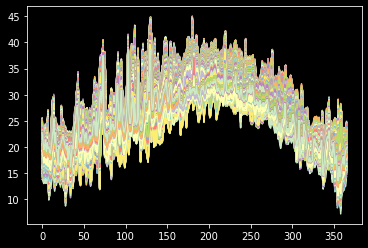

In [32]:
try:
    with plt.style.context('dark_background'):
        for i in  [0,20,36]:
            a= [tempreture_data[i*366+(366-j):i*366+366-j +1,:,:].flatten() for j in reversed(range(366))]
            plt.plot(np.arange(366),a)
except:
    pass

**it's a mess we should smooth the data to get an clear result**

In [33]:
avg_temp_day_over_years =[[((cleaned_temp[j*365+ i,:,:] + cleaned_temp_min[j*365+ i,:,:])/2.0).flatten().mean()
 for i in range(365)
 ]
 for j in range(2017-1981+1)
 ]

In [34]:
df_avg= pd.DataFrame(avg_temp_day_over_years)
df_avg.head(2)

0          1          2          3          4          5    \
0  13.130529  13.480419  13.874324  13.914237  12.263430  12.723754   
1  14.499460  14.703599  13.938771  13.281879  11.659132  13.117598   

         6          7          8          9    ...        355        356  \
0  13.435273  12.939741  12.742347   9.939656  ...  16.557119  16.639899   
1  13.029386  13.633466  13.684152  12.363978  ...  12.872550  13.119509   

         357        358        359        360        361        362  \
0  16.763365  15.811392  16.840340  17.693121  14.124353  14.122714   
1  13.249104  13.906401  15.562455  16.133072  12.183122  13.013993   

         363        364  
0  15.148372  15.611945  
1  12.014766  12.456019  

[2 rows x 365 columns]

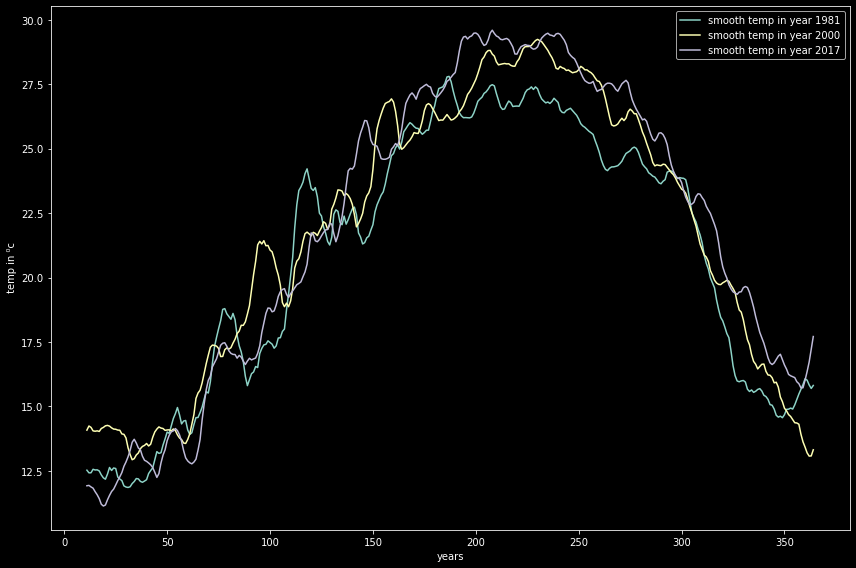

In [35]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(12,8))
    plt.plot(np.arange(365),pd.DataFrame(np.array(avg_temp_day_over_years)[0,:]).rolling(window=12).mean());
    plt.plot(np.arange(365),pd.DataFrame(np.array(avg_temp_day_over_years)[20,:]).rolling(window=12).mean());
    plt.plot(np.arange(365),pd.DataFrame(np.array(avg_temp_day_over_years)[-1,:]).rolling(window=12).mean());
    plt.xlabel("years")
    plt.ylabel(" temp in ⁰c")
    plt.legend(['smooth temp in year 1981','smooth temp in year 2000','smooth temp in year 2017'])
    plt.tight_layout()

* **We could see that in year 2017 it had the lowest overall temp in the first 60 days of the year (Jan , Feb)**
* **And highest overall temp peak from day 150 (May, in spring) to the end of the year**


<a id='2'></a>
### **mean t-max change in 11,12,01,02 months of the year (represents the winter in egypt)**

In [36]:
times[30+30+29], times[273+151],    2017-1981+1

(19810331.0, 19820301.0, 37)

In [37]:
mean_t_max_over_years = dict()
temps=[]
for i in range(2017-1981+1):
    temps.append(np.mean(cleaned_temp[ i*365+273 : i*365 +273+151  ,:,:]))

mean_t_max_over_years['temp'] = temps

In [38]:
mean_df = pd.DataFrame(mean_t_max_over_years)
mean_df.head(3)

temp
0  22.375765
1  21.198111
2  22.430492

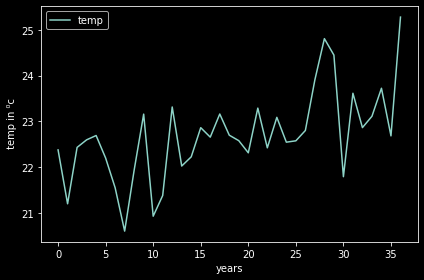

In [39]:
with plt.style.context('dark_background'):
    mean_df.plot()
    plt.xlabel("years")
    plt.ylabel(" temp in ⁰c")
    plt.tight_layout()

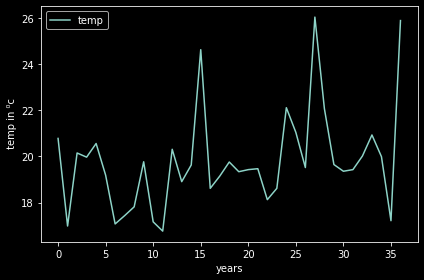

In [40]:
"what people really experince in everyday life "
mode_t_max_over_years = dict()
temps=[]
for i in range(2017-1981+1):
    temps.append(stats.mode(tempreture_data[ i*365+273 : i*365 +273+151  ,:,:].flatten())[0][0])
mode_t_max_over_years['temp'] = temps

mode_df = pd.DataFrame(mode_t_max_over_years)
with plt.style.context('dark_background'):
    mode_df.plot();
    plt.xlabel("years")
    plt.ylabel(" temp in ⁰c")
    plt.tight_layout()

<a id='3'></a>
### **mean t-min change in 11,12,01,02 months of the year (represents the winter in egypt)**

In [41]:
mean_t_min_over_years = dict()
temps=[]
for i in range(2017-1981+1):
    temps.append(np.mean(cleaned_temp_min[ i*365+273 : i*365 +273+151  ,:,:]))

mean_t_min_over_years['temp'] = temps

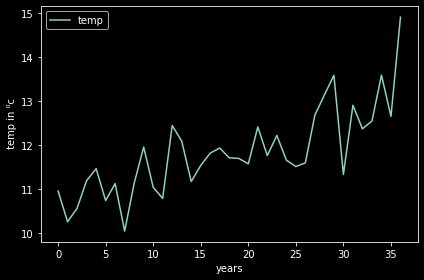

In [42]:
mean_df_ = pd.DataFrame(mean_t_min_over_years)
with plt.style.context('dark_background'):
    mean_df_.plot(); 
    plt.xlabel("years")
    plt.ylabel(" temp in ⁰c")
    plt.tight_layout()

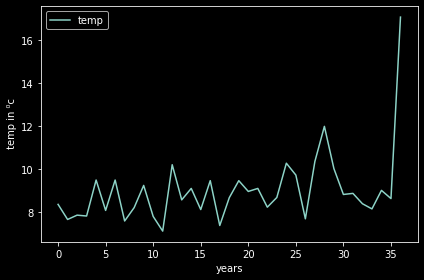

In [43]:
mode_t_min_over_years = dict()
temps=[]
for i in range(2017-1981+1):    
    temps.append(stats.mode(tempreture_data_[ i*365+273 : i*365 +273+151  ,:,:].flatten())[0][0])

mode_t_min_over_years['temp'] = temps
mode_df_ = pd.DataFrame(mode_t_min_over_years)
with plt.style.context('dark_background'):
    mode_df_.plot(); 
    plt.xlabel("years")
    plt.ylabel(" temp in ⁰c")
    plt.tight_layout()

<a id='conc'></a>
## ***Conclusion***
* We could see that how climate change in central egypt over the years
* In winter the climate becomes colder than before
* And summer gets hotter every year